# **Intelligent Transportation Systems** | Project

# **`Vehicle Trajectory Data Extraction`**

## Name: `MD Shafaque`

## Roll No: `B231071CE`




In [ ]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00


In [ ]:
# vehicle_trajectories_auto.py
# it Requires: ultralytics, opencv-python(-headless), pandas, numpy, tqdm
import os
import cv2
import numpy as np
import pandas as pd
import math
import subprocess
import json
from ultralytics import YOLO
from collections import deque
from tqdm import tqdm

# USer PARAMETERS
VIDEO_PATH = '/content/drive/MyDrive/Omassery1.mp4'
OUTPUT_CSV = 'trajectories.csv'
OUTPUT_DIR = 'trajectories_per_vehicle'
YOLO_MODEL = 'yolov8n.pt'
CONFIDENCE_THRESHOLD = 0.35
FRAME_SKIP = 1                         # process every frame; wee can  increase to speeed it up
ASSUME_LANE_WIDTH_M = 3.5              # used for lane based scale
ASSUME_CAR_LENGTH_M = 4.5              # used for car sized heuristic
# ----------------------------------------------------

os.makedirs(OUTPUT_DIR, exist_ok=True)
np.random.seed(42)


#  utilities bellow.
def xyxy_to_centroid(box):
    x1, y1, x2, y2 = box
    return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = max(0, boxA[2]-boxA[0]) * max(0, boxA[3]-boxA[1])
    boxBArea = max(0, boxB[2]-boxB[0]) * max(0, boxB[3]-boxB[1])
    union = boxAArea + boxBArea - interArea
    if union == 0:
        return 0
    return interArea / union

In [ ]:
class SimpleTracker:
    def __init__(self, max_lost=30, iou_threshold=0.3):
        self.next_object_id = 0
        self.objects = dict()
        self.lost = dict()
        self.traces = dict()  # deque of centroids (pixels-> wewill hav to make it m by scale factor)
        self.max_lost = max_lost
        self.iou_threshold = iou_threshold

    def update(self, detections):
        # detections: list of[x1,y1,x2,y2,score,class]
        matched_ids = set()
        updated_objects = dict()
        if len(self.objects) == 0:
            for det in detections:
                self.register(det)
            return list(self.objects.items())

        dets = [d[:4] for d in detections]
        obj_ids = list(self.objects.keys())
        iou_matrix = []
        for oid in obj_ids:
            row = [iou(self.objects[oid], d) for d in dets]
            iou_matrix.append(row)
        iou_matrix = np.array(iou_matrix)
        if iou_matrix.size > 0:
            while True:
                idx = np.unravel_index(np.argmax(iou_matrix, axis=None), iou_matrix.shape)
                maxval = iou_matrix[idx]
                if maxval < self.iou_threshold:
                    break
                obj_idx, det_idx = idx
                oid = obj_ids[obj_idx]
                det = detections[det_idx]
                updated_objects[oid] = det[:4]
                matched_ids.add(det_idx)
                iou_matrix[obj_idx, :] = -1
                iou_matrix[:, det_idx] = -1

        for oid, bbox in updated_objects.items():
            self.objects[oid] = bbox
            self.lost[oid] = 0
            c = xyxy_to_centroid(bbox)
            self.traces[oid].append(c)

        for i, det in enumerate(detections):
            if i in matched_ids:
                continue
            self.register(det)

        unmatched_obj_ids = set(obj_ids) - set(updated_objects.keys())
        for oid in unmatched_obj_ids:
            self.lost[oid] += 1

        to_delete = [oid for oid, l in self.lost.items() if l > self.max_lost]
        for oid in to_delete:
            self.deregister(oid)
        return list(self.objects.items())

    def register(self, det):
        bbox = det[:4]
        oid = self.next_object_id
        self.next_object_id += 1
        self.objects[oid] = bbox
        self.lost[oid] = 0
        self.traces[oid] = deque(maxlen=200)
        self.traces[oid].append(xyxy_to_centroid(bbox))

    def deregister(self, oid):
        try:
            del self.objects[oid]
            del self.lost[oid]
            del self.traces[oid]
        except KeyError:
            pass


In [ ]:
# scale estimation
def try_ffprobe_for_scale(video_path):
    """Try to read tags via ffprobe that might hint altitude; returns tuple ('altitude', value) or None."""
    try:
        cmd = ['ffprobe', '-v', 'quiet', '-print_format', 'json', '-show_format', '-show_streams', video_path]
        proc = subprocess.run(cmd, capture_output=True, text=True)
        out = proc.stdout
        if not out:
            return None
        info = json.loads(out)
        format_tags = info.get('format', {}).get('tags', {}) or {}
        for key in format_tags:
            v = format_tags[key]
            if 'alt' in key.lower() or 'altitude' in key.lower():
                try:
                    alt = float(v)
                    return ('altitude', alt)
                except:
                    continue
        for s in info.get('streams', []):
            tags = s.get('tags', {}) or {}
            for key in tags:
                v = tags[key]
                if 'alt' in key.lower() or 'altitude' in key.lower():
                    try:
                        alt = float(v)
                        return ('altitude', alt)
                    except:
                        continue
    except Exception:
        return None
    return None

In [ ]:
def estimate_scale_by_lane(frame, debug=False):
    """Detect long roughly parallel lines (road edges) and assume lane width = ASSUME_LANE_WIDTH_M."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150)
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=80, minLineLength=80, maxLineGap=40)
    if lines is None:
        return None
    lines = lines[:,0,:]
    angles = np.arctan2(lines[:,3]-lines[:,1], lines[:,2]-lines[:,0])
    angles_deg = np.degrees(angles)
    if len(angles_deg) < 4:
        return None
    median_angle = np.median(angles_deg)
    sel = lines[np.abs(angles_deg - median_angle) < 20]
    if len(sel) < 2:
        return None
    dists = []
    for i in range(len(sel)):
        x1,y1,x2,y2 = sel[i]
        A = y2 - y1
        B = x1 - x2
        C = x2*y1 - x1*y2
        for j in range(i+1, len(sel)):
            x3,y3,x4,y4 = sel[j]
            mx = (x3+x4)/2
            my = (y3+y4)/2
            denom = math.hypot(A,B)
            if denom == 0:
                continue
            dist = abs(A*mx + B*my + C) / denom
            dists.append(dist)
    if len(dists) == 0:
        return None
    median_dist = np.median(dists)
    pixels_per_m = median_dist / ASSUME_LANE_WIDTH_M
    if debug:
        print('lane median_dist pixels:', median_dist, '-> pixels_per_m', pixels_per_m)
    return pixels_per_m


## ***Scale Estimation***

In [ ]:
def estimate_scale_by_car_size(frame, detections):
    """Given detections on a frame, use median bbox length to estimate pixels_per_m."""
    lengths = []
    for d in detections:
        x1,y1,x2,y2,score,cls = d
        if int(cls) in [2,3,5,7]:
            lengths.append(abs(x2-x1))
    if len(lengths) == 0:
        return None
    med_len = float(np.median(lengths))
    pixels_per_m = med_len / ASSUME_CAR_LENGTH_M
    return pixels_per_m

def auto_estimate_pixels_per_metre(video_path, model, sample_frame_index=None, debug=False):
    # reading a sample frame
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    if total == 0:
        cap.release()
        raise RuntimeError('Cannot read video or zero frames')
    if sample_frame_index is None:
        sample_frame_index = max(0, total//10)
    cap.set(cv2.CAP_PROP_POS_FRAMES, sample_frame_index)
    ret, frame = cap.read()
    if not ret:
        cap.release()
        raise RuntimeError('Cannot read sample frame')

    # Try ffprobe for metadata altitude
    meta = try_ffprobe_for_scale(video_path)
    if meta is not None:
        # we return metadata so user can use it with known camera params if they have them
        if debug:
            print('Found metadata via ffprobe:', meta)
        cap.release()
        return None, meta

    # Try lane detection
    lane_scale = estimate_scale_by_lane(frame, debug=debug)
    if lane_scale is not None and lane_scale > 0:
        cap.release()
        return lane_scale, ('lane', None)

    # Try car-size heuristic by running detection on the sample frame
    results = model(frame, conf=CONFIDENCE_THRESHOLD, verbose=False)
    r = results[0]
    dets = []
    for box in r.boxes.data.tolist():
        x1,y1,x2,y2,score,cls = box
        dets.append([x1,y1,x2,y2,score,cls])
    car_scale = estimate_scale_by_car_size(frame, dets)
    if car_scale is not None and car_scale > 0:
        cap.release()
        return car_scale, ('car', None)

    cap.release()
    return None, None

## ***Main Processing***


In [ ]:
# main processing
def process_video(video_path, model_name, output_csv, output_dir, frame_skip=1, conf_thresh=0.35, debug=False):
    model = YOLO(model_name)
    print('Estimating pixels_per_metre automatically (ffprobe -> lane -> car heuristic)...')
    ppm, ppm_source = auto_estimate_pixels_per_metre(video_path, model, debug=debug)
    if ppm is None:
        print('Automatic scale estimation could not determine pixels_per_metre.')
        print('Proceeding with pixel units (speeds in px/s). For meter-accurate results, provide a reference or telemetry.')
        use_metres = False
    else:
        print(f'Estimated pixels_per_metre = {ppm:.3f} (source: {ppm_source})')
        use_metres = True

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    print(f'Video FPS: {fps}, total frames: {frame_count}')

    tracker = SimpleTracker(max_lost=30, iou_threshold=0.3)
    rows = []
    frame_idx = 0
    pbar = tqdm(total=max(1, frame_count//frame_skip))
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_skip != 0:
            frame_idx += 1
            continue
        results = model(frame, conf=conf_thresh, verbose=False)
        r = results[0]
        dets = []
        for box in r.boxes.data.tolist():
            x1, y1, x2, y2, score, cls = box
            cls = int(cls)
            # COCO vehicle ids are as: car=2, motorcycle=3, bus=5, truck=7
            if cls in [2,3,5,7]:
                dets.append([x1,y1,x2,y2,score,cls])
        tracker.update(dets)
        current_time = frame_idx / fps
        for oid, bbox in tracker.objects.items():
            x1,y1,x2,y2 = bbox
            cx, cy = xyxy_to_centroid(bbox)
            if use_metres:
                x_m = cx / ppm
                y_m = cy / ppm
            else:
                x_m = cx
                y_m = cy
            speed = None
            acc = None
            trace = tracker.traces.get(oid, None)
            if trace is not None and len(trace) >= 2:
                px, py = trace[-2]
                nx, ny = trace[-1]
                dx = (nx - px)
                dy = (ny - py)
                if use_metres:
                    dx /= ppm; dy /= ppm
                dist = math.hypot(dx, dy)
                dt = (1.0 / fps) * frame_skip
                speed = dist / dt if dt>0 else 0.0
                if len(trace) >= 3:
                    px2, py2 = trace[-3]
                    if use_metres:
                        px2 /= ppm; py2 /= ppm
                    dx_prev = px - px2
                    dy_prev = py - py2
                    if use_metres:
                        dx_prev /= ppm; dy_prev /= ppm
                    dist_prev = math.hypot(dx_prev, dy_prev)
                    speed_prev = dist_prev / dt if dt>0 else 0.0
                    acc = (speed - speed_prev) / dt
            rows.append({
                'Vehicle_ID': oid,
                'Frame_No': frame_idx,
                'Time_s': current_time,
                'X_m_or_px': x_m,
                'Y_m_or_px': y_m,
                'Speed_mps_or_pxps': speed,
                'Acc_mps2_or_pxps2': acc,
                'used_metres': use_metres,
                'bbox_x1': x1,'bbox_y1': y1,'bbox_x2': x2,'bbox_y2': y2
            })
        frame_idx += 1
        pbar.update(1)
    pbar.close()
    cap.release()

    df = pd.DataFrame(rows)
    if df.empty:
        print('No rows produced — check detection thresholds and video content.')
        return df

    if use_metres:
        df = df.rename(columns={'X_m_or_px':'X_m','Y_m_or_px':'Y_m','Speed_mps_or_pxps':'Speed_mps','Acc_mps2_or_pxps2':'Acc_mps2'})
    else:
        df = df.rename(columns={'X_m_or_px':'X_px','Y_m_or_px':'Y_px','Speed_mps_or_pxps':'Speed_pxps','Acc_mps2_or_pxps2':'Acc_pxps2'})

    df = df.sort_values(['Vehicle_ID','Frame_No'])
    df.to_csv(output_csv, index=False)
    print('Saved aggregated trajectories to', output_csv)

    # per-vehicle CSVs
    for vid, g in df.groupby('Vehicle_ID'):
        g.to_csv(os.path.join(output_dir, f'vehicle_{vid}.csv'), index=False)
    print('Saved per-vehicle CSVs to', output_dir)
    return df

# run as script
if __name__ == '__main__':
    print('Processing...', VIDEO_PATH)
    df = process_video(VIDEO_PATH, YOLO_MODEL, OUTPUT_CSV, OUTPUT_DIR, FRAME_SKIP, CONFIDENCE_THRESHOLD, debug=True)
    print('Done. Example rows:')
    print(df.head())

Processing... /content/drive/MyDrive/Omassery1.mp4
Estimating pixels_per_metre automatically (ffprobe -> lane -> car heuristic)...
lane median_dist pixels: 655.8713901212793 -> pixels_per_m 187.39182574893695
Estimated pixels_per_metre = 187.392 (source: ('lane', None))
Video FPS: 23.976023976023978, total frames: 24022


100%|██████████| 24022/24022 [14:45<00:00, 27.12it/s]


Saved aggregated trajectories to trajectories.csv
Saved per-vehicle CSVs to trajectories_per_vehicle
Done. Example rows:
   Vehicle_ID  Frame_No    Time_s       X_m       Y_m  Speed_mps  Acc_mps2  \
0           0       174  7.257250  9.182252  6.286815        NaN       NaN   
1           0       175  7.298958  9.182252  6.286815        NaN       NaN   
2           0       176  7.340667  9.182252  6.286815        NaN       NaN   
3           0       177  7.382375  9.182252  6.286815        NaN       NaN   
4           0       178  7.424083  9.182252  6.286815        NaN       NaN   

   used_metres      bbox_x1      bbox_y1     bbox_x2      bbox_y2  
0         True  1615.114258  1109.858398  1826.24353  1246.336914  
1         True  1615.114258  1109.858398  1826.24353  1246.336914  
2         True  1615.114258  1109.858398  1826.24353  1246.336914  
3         True  1615.114258  1109.858398  1826.24353  1246.336914  
4         True  1615.114258  1109.858398  1826.24353  1246.336914  


## ***Speed & Acceleration Computation***

In [17]:
import pandas as pd
import numpy as np


df = pd.read_csv("trajectories.csv")

# Sorting by vehicle I D and frame number
df = df.sort_values(by=["Vehicle_ID", "Frame_No"])

# Initializng new columns
df["Speed_mps"] = np.nan
df["Acc_mps2"] = np.nan

# define  scale factr (meters  per pixel)
scale_factor = 0.05  # will change as per users calibration
fps = 30  # to beupdated with actual video FPS

# If Time_s not already correct, re-compute it frm frame number
if "Time_s" not in df.columns or df["Time_s"].isnull().all():
    df["Time_s"] = df["Frame_No"] / fps

# Compute speed and acceleration for each vehicle
for vid in df["Vehicle_ID"].unique():
    temp = df[df["Vehicle_ID"] == vid].copy()

    # Differences in X, Y, and time
    temp["dx"] = temp["X_m"].diff()
    temp["dy"] = temp["Y_m"].diff()
    temp["dt"] = temp["Time_s"].diff()

    # Distance between consecutive positions
    temp["dist_m"] = np.sqrt(temp["dx"]**2 + temp["dy"]**2)

    # Speed = distance / time
    temp["Speed_mps"] = temp["dist_m"] / temp["dt"]

    # Acceleration = Δspeed / Δtime
    temp["Acc_mps2"] = temp["Speed_mps"].diff() / temp["dt"]

    # Update back to main datafrm
    df.loc[temp.index, ["Speed_mps", "Acc_mps2"]] = temp[["Speed_mps", "Acc_mps2"]]

# Save new CSV
df.to_csv("trajectory_with_speed_accel.csv", index=False)

print("✅ Speed and acceleration computed successfully!")


✅ Speed and acceleration computed successfully!


# `Evaluation`

In [18]:
pip install trackeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 142.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 132.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 12.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotli

## ***Trajectory Smoothness & Continuity Evaluation***

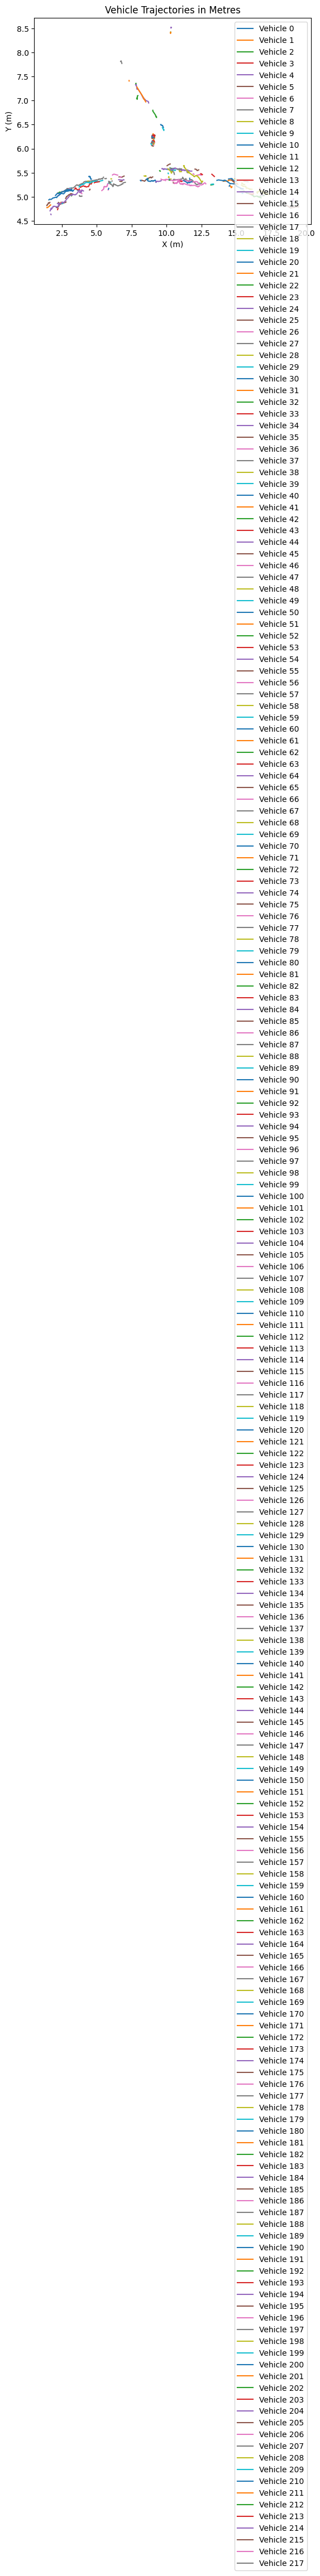

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("trajectory_with_speed_accel.csv")

for vid in df["Vehicle_ID"].unique():
    temp = df[df["Vehicle_ID"] == vid]
    plt.plot(temp["X_m"], temp["Y_m"], label=f"Vehicle {vid}")

plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Vehicle Trajectories in Metres")
plt.legend()
plt.show()


## ***Speed & Acceleration Plausibility Evaluation***

In [20]:
print(df["Speed_mps"].describe())
print(df["Acc_mps2"].describe())


count    9986.000000
mean        0.143574
std         0.546670
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.663815
Name: Speed_mps, dtype: float64
count    9768.000000
mean       -0.109901
std        17.334694
min      -240.571801
25%         0.000000
50%         0.000000
75%         0.000000
max       255.675893
Name: Acc_mps2, dtype: float64


## ***Physical Consistency Evaluation***


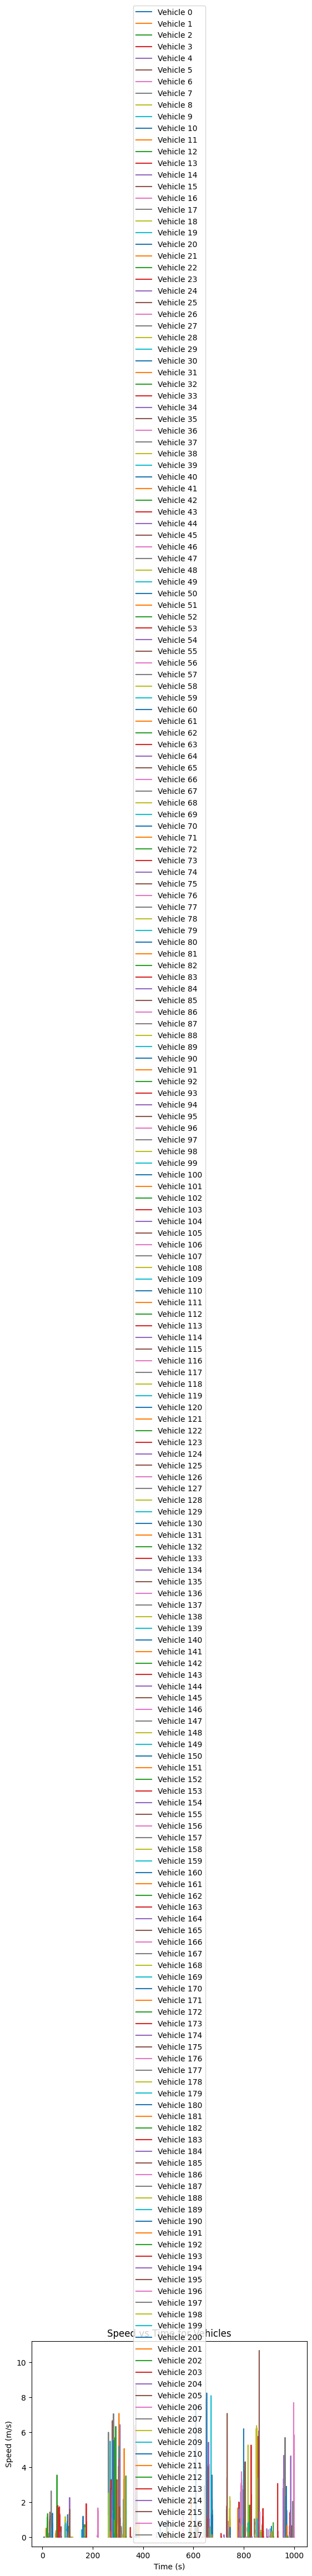

In [21]:
for vid in df["Vehicle_ID"].unique():
    temp = df[df["Vehicle_ID"] == vid]
    plt.plot(temp["Time_s"], temp["Speed_mps"], label=f"Vehicle {vid}")

plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.title("Speed vs Time for Vehicles")
plt.legend()
plt.show()


## ***Aggregate Statistics Evaluation***

In [22]:
summary = df.groupby("Vehicle_ID").agg({
    "Speed_mps": ["mean", "max"],
    "Acc_mps2": ["mean", "max"],
    "X_m": ["min", "max"],
    "Y_m": ["min", "max"]
})
summary["Total_Distance_m"] = (
    (summary["X_m"]["max"] - summary["X_m"]["min"])**2 +
    (summary["Y_m"]["max"] - summary["Y_m"]["min"])**2
)**0.5

summary.columns = ['_'.join(col) for col in summary.columns]
summary.to_csv("trajectory_summary.csv")
print(summary.head())


            Speed_mps_mean  Speed_mps_max  Acc_mps2_mean  Acc_mps2_max  \
Vehicle_ID                                                               
0                 0.000000       0.000000   0.000000e+00      0.000000   
1                 0.084769       0.498504  -5.449914e-14     10.760221   
2                 0.151841       1.332751  -9.279918e-02     23.639707   
3                 0.000000       0.000000   0.000000e+00      0.000000   
4                 0.058075       1.221789  -4.605121e-14     29.293643   

             X_m_min   X_m_max   Y_m_min   Y_m_max  Total_Distance_m_  
Vehicle_ID                                                             
0           9.182252  9.182252  6.286815  6.286815           0.000000  
1           9.029793  9.069238  6.286596  6.309089           0.045408  
2           9.003693  9.144066  6.254065  6.283855           0.143499  
3           3.186566  3.186566  5.156098  5.156098           0.000000  
4           9.068396  9.160941  6.267331  6.28439

## ***Overlay Trajectories on Video***

In [23]:
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

# USER INPUTS
input_video = "/content/drive/MyDrive/Omassery1.mp4"     # path to your input drone video
trajectory_csv = "trajectory_with_speed_accel.csv"   # path to processed CSV
output_video = "overlay_trajectory.mp4"  # output file name
trail_length = 15   # number of past points to show per vehicle
frame_skip = 1      # 1 = every frame, 2 = every second frame (faster)

# LOAD DATA
df = pd.read_csv(trajectory_csv)
df = df.sort_values(by=["Frame_No"])

# PREPARE VIDEO
cap = cv2.VideoCapture(input_video)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps/frame_skip, (width, height))

# Random colors for each vehicle
vehicle_colors = {
    vid: tuple(np.random.randint(100, 255, size=3).tolist())
    for vid in df["Vehicle_ID"].unique()
}

# DRAW LOOP
frame_idx = 0
pbar = tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), desc="Rendering video")

while True:
    ret, frame = cap.read()
    if not ret:
        break
    if frame_idx % frame_skip != 0:
        frame_idx += 1
        continue

    # Get data for current frame
    frame_data = df[df["Frame_No"] == frame_idx]

    for _, row in frame_data.iterrows():
        vid = int(row["Vehicle_ID"])
        color = vehicle_colors[vid]
        x1, y1, x2, y2 = int(row["bbox_x1"]), int(row["bbox_y1"]), int(row["bbox_x2"]), int(row["bbox_y2"])
        cx, cy = int((x1 + x2)/2), int((y1 + y2)/2)

        # Draw bbox and label
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f"ID {vid}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Draw trajectory trail (past 15 points)
        history = df[(df["Vehicle_ID"] == vid) & (df["Frame_No"].between(frame_idx - trail_length, frame_idx))]
        pts = np.array([[int((a+b)/2), int((c+d)/2)] for a,b,c,d in zip(history["bbox_x1"], history["bbox_x2"], history["bbox_y1"], history["bbox_y2"])])
        for j in range(1, len(pts)):
            cv2.line(frame, tuple(pts[j-1]), tuple(pts[j]), color, 2)

    out.write(frame)
    frame_idx += 1
    pbar.update(1)

pbar.close()
cap.release()
out.release()
print(f"✅ Done! Overlay video saved as {output_video}")


Rendering video: 100%|██████████| 24022/24022 [39:10<00:00, 10.22it/s]

✅ Done! Overlay video saved as overlay_trajectory.mp4
